In [28]:
!pip install -q -U keras-tuner

In [29]:
import numpy as np                               # linear algebra
import pandas as pd                              # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import re                                        # to handle regular expressions
from string import punctuation                   # to extract the puntuation symbols
import nltk
from nltk.tokenize import word_tokenize          # to divide strings into tokens
from nltk.stem import WordNetLemmatizer          # to lemmatize the tokens
from nltk.corpus import stopwords                # to remove the stopwords 

import random                                    # for generating (pseudo-)random numbers
import matplotlib.pyplot as plt                  # to plot some visualizations

import tensorflow as tf            
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.layers import Embedding
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch
from kerastuner.tuners import BayesianOptimization
from kerastuner.tuners import Hyperband
import kerastuner as kt

In [30]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [31]:
directory = '/content/drive/MyDrive/Capstone/Data/splits'
directory2 = '/content/drive/MyDrive/Capstone/Data/Scraped'

In [32]:
train_data = pd.read_csv(os.path.join(directory, 'InformativenessTrain_Processed.csv'))
test_data  = pd.read_csv(os.path.join(directory, 'InformativenessTest_Processed.csv'))

In [33]:
train_data.dtypes

id                   int64
event               object
source              object
text                object
lang                object
lang_confidence    float64
class_label         object
class_label_cat      int64
processed_txt       object
dtype: object

In [33]:
# cleaning the text

def clean_text(text):
    '''Make text lowercase, remove links,remove punctuation
    and remove words containing numerals.'''
    text = text.lower()
    #get rid of usernames
    tweet_words = text.strip('\r').split(' ')
    for word in [word for word in tweet_words if '@' in word]:
            
            text = text.replace(word, "")
    #get rid of the re-tweet
    tweet_words = text.strip('\r').split(' ')
    for word in [word for word in tweet_words if 'rt' == word]:
            
            text = text.replace(word, "")
            
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('[%s]' % re.escape(punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text
def remove_stopwords(text):
    words = [w for w in text if w not in stopwords.words('english')]
    return words
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(w) for w in text]  ##Notice the use of text.
def concatenate_text(text):
    return ' '.join(text)

In [34]:
# Applying the cleaning function to both test, train, and scraped datasets
train_data['text'] = train_data['text'].apply(lambda x: clean_text(x))
test_data['text'] = test_data['text'].apply(lambda x: clean_text(x))
train_data['text'] = train_data['text'].apply(lambda x:word_tokenize(x))
test_data['text'] = test_data['text'].apply(lambda x:word_tokenize(x))
train_data['text'] = train_data['text'].apply(lambda x : remove_stopwords(x))
test_data['text'] = test_data['text'].apply(lambda x : remove_stopwords(x))
train_data['text'] = train_data['text'].apply(lambda x : lemmatize_text(x))
test_data['text'] = test_data['text'].apply(lambda x : lemmatize_text(x))
train_data['text'] = train_data['text'].apply(lambda x : concatenate_text(x))
test_data['text'] = test_data['text'].apply(lambda x : concatenate_text(x))
twts['ptext'] = twts['Text'].apply(lambda x: clean_text(x))
twts['ptext'] = twts['ptext'].apply(lambda x: word_tokenize(x))
twts['ptext'] = twts['ptext'].apply(lambda x : remove_stopwords(x))
twts['ptext'] = twts['ptext'].apply(lambda x : lemmatize_text(x))
twts['ptext'] = twts['ptext'].apply(lambda x : concatenate_text(x))

In [35]:
train_data.head()

,id,event,source,text,lang,lang_confidence,class_label,class_label_cat,processed_txt
0,297352412203737088,2013_queensland_floods-ontopic,crisislext6,interesting flood bit trivia third successive ...,en,1.0,informative,0,and an interesting flood bit of trivia this is...
1,324545795107999744,2013_boston_bombings-ontopic,crisislext6,reddit scour photo search boston bombing suspect,en,1.0,informative,0,reddit scours photos in search of boston bombi...
2,262631468403138560,2012_sandy_hurricane-ontopic,crisislext6,late brunch sandy hope garage,en,1.0,informative,0,late brunch before #sandy with hope garage
3,916246594797953024,disaster_events,aidr_system,travelalert usa nnlatest update summary tropic...,en,NaN,informative,0,#travelalert usa n nlatest update summary trop...
4,24526,disaster_events,drd-figureeight-multimedia,long earth still rotates bowel earth keep prod...,en,1.0,informative,0,as long as the earth still rotates the bowels ...


In [36]:
# print("processing ")
# procstart =  datetime.datetime.now() 
# twts['ptext'] = twts['Text'].apply(lambda x: clean_text(x))
# twts['ptext'] = twts['ptext'].apply(lambda x: word_tokenize(x))
# twts['ptext'] = twts['ptext'].apply(lambda x : remove_stopwords(x))
# twts['ptext'] = twts['ptext'].apply(lambda x : lemmatize_text(x))
# twts['ptext'] = twts['ptext'].apply(lambda x : concatenate_text(x))
# twts.to_csv(os.path.join(tweet_dir,"processed_{}_{}.csv".format(since_date.replace('-',''),until_date.replace('-',''))), index = False)
# procend=  datetime.datetime.now()


# print("processed {}".format(procend - procstart))

In [37]:
train_data.to_csv(os.path.join(directory,"train_data.csv"),index = False)
test_data.to_csv(os.path.join(directory,"test_data.csv"),index = False)

In [38]:
# !wget -P /content/drive/MyDrive/Capstone https://nlp.stanford.edu/data/wordvecs/glove.twitter.27B.zip

In [39]:
# !unzip "/content/drive/MyDrive/Capstone/WordVector.zip"  -d "/content/drive/MyDrive/Capstone/WordVector" 

In [40]:
path_to_glove_file = '/content/drive/MyDrive/Capstone/WordVector/WordVector/glove.twitter.27B.200d.txt'
embeddings_index = {}
f = open(path_to_glove_file, 'r', encoding='utf8')
for line in f:
    splitLine = line.split(' ')
    word = splitLine[0]                                  # the first entry is the word
    coefs = np.asarray(splitLine[1:], dtype='float32')   # these are the vectors representing word embeddings
    embeddings_index[word] = coefs
print("Glove data loaded! In total:",len(embeddings_index)," words.")

Glove data loaded! In total: 1193515  words.


In [ ]:
def train_val_split(df, validation_split):
    """
    This function generates the training and validation splits from an input dataframe
    
    Parameters:
        dataframe: pandas dataframe with columns "text" and "target" (binary)
        validation_split: should be between 0.0 and 1.0 and represent the proportion of the dataset to 
        include in the validation split
    
    Returns:
        train_samples: list of strings in the training dataset
        val_samples: list of strings in the validation dataset
        train_labels: list of labels (0 or 1) in the training dataset
        val_labels: list of labels (0 or 1) in the validation dataset      
    """
       
    text = df['text'].values.tolist()                         # input text as list
    targets = df['class_label_cat'].values.tolist()                    # targets
    
#   Preparing the training/validation datasets
    
    seed = random.randint(1,50)   # random integer in a range (1, 50)
    rng = np.random.RandomState(seed)
    rng.shuffle(text)
    rng = np.random.RandomState(seed)
    rng.shuffle(targets)

    num_validation_samples = int(validation_split * len(text))

    train_samples = text[:-num_validation_samples]
    val_samples = text[-num_validation_samples:]
    train_labels = targets[:-num_validation_samples]
    val_labels = targets[-num_validation_samples:]
    
    print(f"Total size of the dataset: {df.shape[0]}.")
    print(f"Training dataset: {len(train_samples)}.")
    print(f"Validation dataset: {len(val_samples)}.")
    
    return train_samples, val_samples, train_labels, val_labels
train_samples, val_samples, train_labels, val_labels = train_val_split(train_data, 0.25)

In [ ]:
def test_listerine(df):
    """
    This function generates the test x and y from an input dataframe
    
    Parameters:
        dataframe: pandas dataframe with columns "text" and "class_label_cat" (binary)
        
    
    Returns:
        test_samples: list of strings in the training dataset

        test_labels: list of labels (0 or 1) in the training dataset
    
    """
       
    text = df['text'].values.tolist()                         # input text as list
    targets = df['class_label_cat'].values.tolist()                    # targets
    
#   Preparing the training/validation datasets
    
    seed = random.randint(1,50)   # random integer in a range (1, 50)
    rng = np.random.RandomState(seed)
    rng.shuffle(text)
    rng = np.random.RandomState(seed)
    rng.shuffle(targets)

   

    test_samples = text
   
    test_labels = targets
    
    
    print(f"Total size of the dataset: {df.shape[0]}.")

    
    return test_samples, test_labels
test_samples, test_labels = test_listerine(test_data)

In [ ]:
test_samples[1:5]

In [ ]:
def make_embedding_matrix(train_samples, val_samples, embeddings_index):
    """
    This function computes the embedding matrix that will be used in the embedding layer
    
    Parameters:
        train_samples: list of strings in the training dataset
        val_samples: list of strings in the validation dataset
        embeddings_index: Python dictionary with word embeddings
    
    Returns:
        embedding_matrix: embedding matrix with the dimensions (num_tokens, embedding_dim), 
        where num_tokens is the vocabulary of the input data, 
        and emdebbing_dim is the number of components in the GloVe vectors (can be 50,100,200,300)
        vectorizer: TextVectorization layer      
    """
    
    vectorizer = TextVectorization(max_tokens=55000, output_sequence_length=50)
    text_ds = tf.data.Dataset.from_tensor_slices(train_samples).batch(128)
    vectorizer.adapt(text_ds)
    
    voc = vectorizer.get_vocabulary()
    word_index = dict(zip(voc, range(len(voc))))
      
    num_tokens = len(voc)
    
    hits = 0
    misses = 0

#   creating an embedding matrix
    embedding_dim = len(embeddings_index['the'])
    embedding_matrix = np.zeros((num_tokens, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros
            embedding_matrix[i] = embedding_vector
            hits += 1
        else:
            misses += 1

#     print("Converted %d words (%d misses)" % (hits, misses))
    print(f"Converted {hits} words ({misses} misses).")

    return embedding_matrix, vectorizer

In [45]:
embedding_matrix, vectorizer = make_embedding_matrix(train_samples, val_samples, embeddings_index)

Converted 32208 words (22792 misses).


In [ ]:
# embedding_matrix
# vectorizer

In [ ]:
# from tensorboard.plugins.hparams import api as hp

In [ ]:
# # HP_DIMENSIONS = hp.HParam('dimensions', hp.Discrete([16,32,64,128]))
# HP_NUM_LSTM1 = hp.HParam('num_lstm1', hp.Discrete([16,32,64,128]))
# HP_NUM_LSTM2= hp.HParam('num_lstm2', hp.Discrete([16, 32,64, 128]))
# HP_NUM_LSTM3= hp.HParam('num_lstm3', hp.Discrete([16, 32,64, 128]))
# HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([16,32,64,128]))
# HP_ACTIVATE = hp.HParam('activator', hp.Discrete(['tanh','relu','sigmoid']))
# HP_ACTIVATE2 = hp.HParam('activator2', hp.Discrete(['tanh','relu','sigmoid']))
# HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete([1e-2,1e-3,1e-4]))
# HP_DROPOUT_IN = hp.HParam('dropout_in_rate', hp.Discrete([0.5, 0.6, 0.7, 0.8, 0.9]))
# HP_DROPOUT_1 = hp.HParam('dropout_1_rate', hp.Discrete([0.3, 0.4, 0.5, 0.6, 0.7]))
# HP_REC_DROPOUT_1 = hp.HParam('rec_dropout_1_rate', hp.Discrete([0.3, 0.4, 0.5, 0.6, 0.7]))
# HP_DROPOUT_2 = hp.HParam('dropout_2_rate', hp.Discrete([0.3, 0.4, 0.5, 0.6, 0.7]))
# HP_REC_DROPOUT_2 = hp.HParam('rec_dropout_2_rate', hp.Discrete([0.3, 0.4, 0.5, 0.6, 0.7]))
# HP_DROPOUT_3 = hp.HParam('dropout_3_rate', hp.Discrete([0.3, 0.4, 0.5, 0.6, 0.7]))
# HP_REC_DROPOUT_3 = hp.HParam('rec_dropout_3_rate', hp.Discrete([0.3, 0.4, 0.5, 0.6, 0.7]))
# HP_DROPOUT = hp.HParam('dropout_rate', hp.Discrete([0.3, 0.4, 0.5, 0.6, 0.7]))
# METRIC_ACCURACY = 'binary_accuracy'

# with tf.summary.create_file_writer('/content/drive/MyDrive/Capstone/logvec/hparam_tuning').as_default():
#     hp.hparams_config(
#         hparams=[HP_NUM_LSTM1,HP_NUM_LSTM2,HP_NUM_LSTM3,
#                  HP_NUM_UNITS, HP_ACTIVATE,  HP_ACTIVATE2, HP_OPTIMIZER,HP_DROPOUT],
#         metrics=[hp.Metric(METRIC_ACCURACY, display_name='binary_accuracy')],)

In [ ]:
# def initialize_nn(embedding_matrix,hparams):
#     """
#     This function initializes Keras model for binary text classification
    
#     # Parameters:
#         embedding matrix with the dimensions (num_tokens, embedding_dim),
#          where num_tokens is the vocabulary size of the input data,
#           and emdebbing_dim is the number of components in the GloVe vectors
    
#     Returns:
#         model: Keras model    
#     """
    
#     num_tokens = embedding_matrix.shape[0]
#     embedding_dim = embedding_matrix.shape[1]
    
#     embedding_layer = Embedding(
#     num_tokens,
#     embedding_dim,
#     embeddings_initializer=keras.initializers.Constant(embedding_matrix),
#     trainable=False,                # we are not going to train the embedding vectors
#     )
    
# #   Here we define the architecture of the Keras model. 
#     int_sequences_input = keras.Input(shape=(None,), dtype="int64")
#     x = embedding_layer(int_sequences_input) 
#     x = layers.Dropout(hparams[HP_DROPOUT])(x)
#     x = layers.Bidirectional(layers.LSTM(hparams[HP_NUM_LSTM3],
#                                          dropout=0.0,recurrent_dropout=0.0, 
#                                          return_sequences=True))(x)
#     x = layers.Bidirectional(layers.LSTM(hparams[HP_NUM_LSTM2],
#                                          dropout=0.0,recurrent_dropout=0.0,
#                                          return_sequences=True))(x)
#     x = layers.Bidirectional(layers.LSTM(hparams[HP_NUM_LSTM1],
#                                          dropout=0.0,recurrent_dropout=0.0, ))(x)
#     # x = layers.Conv1D(128, 3, activation='relu')(x)
#     # x = layers.GlobalMaxPooling1D()(x)
#     x = layers.Dense(hparams[HP_NUM_UNITS],activation= hparams[HP_ACTIVATE])(x)
#     x = layers.Dropout(hparams[HP_DROPOUT])(x)
#     preds = layers.Dense(1, activation=hparams[HP_ACTIVATE2])(x)
#     model = keras.Model(int_sequences_input, preds)

#     print('')
#     print("Training the model...")
    
#     model.compile(loss="binary_crossentropy", 
#               optimizer="adam", 
#               metrics=["binary_accuracy"])
    
#     x_train = vectorizer(np.array([[s] for s in train_samples])).numpy()
#     x_val = vectorizer(np.array([[s] for s in val_samples])).numpy()
#     x_test = vectorizer(np.array([[s] for s in test_samples])).numpy()
#     y_train = np.asarray(train_labels).astype('float32').reshape((-1,1))
#     y_val = np.asarray(val_labels).astype('float32').reshape((-1,1))
#     y_test = np.asarray(test_labels).astype('float32').reshape((-1,1))
    
#     model.fit(x_train, y_train, batch_size=32, epochs=6, 
#              shuffle=True,validation_data=(x_val, y_val),
#              callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=2)], 
#              verbose=1)

#     _, accuracy = model.evaluate(x_test,y_test)
#     return accuracy

In [ ]:
# def run(run_dir, hparams):
#     with tf.summary.create_file_writer(run_dir).as_default():
#         hp.hparams(hparams)  # record the values used in this trial
#         accuracy = initialize_nn(embedding_matrix,hparams)
#         tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)

In [ ]:
# session_num = 0

# for num_lstm1 in HP_NUM_LSTM1.domain.values:
#   for num_lstm2 in HP_NUM_LSTM2.domain.values:
#     for num_lstm3 in HP_NUM_LSTM3.domain.values: 
#       for num_units in HP_NUM_UNITS.domain.values:
#         for activator in HP_ACTIVATE.domain.values:
#           for activator2 in HP_ACTIVATE2.domain.values:
#             for optimizer in HP_OPTIMIZER.domain.values:
#               for dropout_in_rate in HP_DROPOUT_IN.domain.values:
#                 for dropout_1_rate in HP_DROPOUT_1.domain.values:
#                   for rec_dropout_1_rate in HP_REC_DROPOUT_1.domain.values:
#                     for dropout_2_rate in HP_DROPOUT_2.domain.values:
#                       for rec_dropout_2_rate in HP_REC_DROPOUT_2.domain.values:
#                         for dropout_3_rate in HP_DROPOUT_3.domain.values:
#                           for rec_dropout_3_rate in HP_REC_DROPOUT_3.domain.values:
#                             for dropout_rate in HP_DROPOUT.domain.values:
#                               hparams = {
#                                   HP_NUM_LSTM1: num_lstm1,
#                                   HP_NUM_LSTM2: num_lstm2,
#                                   HP_NUM_LSTM3: num_lstm3,
#                                   HP_NUM_UNITS: num_units,
#                                   HP_ACTIVATE: activator,
#                                   HP_ACTIVATE2: activator2,
#                                   HP_OPTIMIZER: optimizer,
#                                   HP_DROPOUT_IN : dropout_in_rate,
#                                   HP_DROPOUT_1 : dropout_1_rate,
#                                   HP_REC_DROPOUT_1 :rec_dropout_1_rate,
#                                   HP_DROPOUT_2 : dropout_2_rate,
#                                   HP_REC_DROPOUT_2 :rec_dropout_2_rate,
#                                   HP_DROPOUT_3 : dropout_3_rate,
#                                   HP_REC_DROPOUT_3 : rec_dropout_3_rate,
#                                   HP_DROPOUT : dropout_rate
#                               }
#                               run_name = "run-%d" % session_num
#                               print('--- Starting trial: %s' % run_name)
#                               print({h.name: hparams[h] for h in hparams})
#                               run('/content/drive/MyDrive/Capstone/logvec2/hparam_tuning/' + run_name, hparams)
#                               session_num += 1

In [ ]:
def initialize_nn(embedding_matrix):
    """
    This function initializes Keras model for binary text classification
    
    Parameters:
        embedding matrix with the dimensions (num_tokens, embedding_dim),
         where num_tokens is the vocabulary size of the input data,
          and emdebbing_dim is the number of components in the GloVe vectors
    
    Returns:
        model: Keras model    
    """
    
    num_tokens = embedding_matrix.shape[0]
    embedding_dim = embedding_matrix.shape[1]
    
    embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,                # we are not going to train the embedding vectors
    )
    
#   Here we define the architecture of the Keras model. 
    int_sequences_input = keras.Input(shape=(None,), dtype="int64")
    x = embedding_layer(int_sequences_input) 
    x = layers.Dropout(.7)(x)
    x = layers.Bidirectional(layers.LSTM(128,                                        
                                          dropout=.4,
                                          return_sequences=True))(x)
    x = layers.Bidirectional(layers.LSTM(32,
                                          dropout=.5))(x)
    x = layers.Dense(128,activation= 'sigmoid')(x)
    x = layers.Dropout(.5)(x)
    preds = layers.Dense(1, activation='sigmoid')(x)
    model = keras.Model(int_sequences_input, preds)
    
    return model

In [ ]:
# initial_model = initialize_nn(embedding_matrix)
# initial_model.summary()

In [ ]:
# !rm -r "/content/drive/MyDrive/Capstone/loggy3"

In [ ]:
def myparamalam(hp):
    """
    This function initializes Keras model for binary text classification
    
    Parameters:
        embedding matrix with the dimensions (num_tokens, embedding_dim),
         where num_tokens is the vocabulary size of the input data,
          and emdebbing_dim is the number of components in the GloVe vectors
    
    Returns:
        model: Keras model    
    """
    hp_num_nodes = hp.Choice('num_units', values =[16,32,64,128])
    hp_activation = hp.Choice('activator',values=['tanh','sigmoid', 'relu'])
    hp_activation2 = hp.Choice('activator2',values=['tanh','sigmoid', 'relu'])
    HP_DROPOUT_IN = hp.Choice('dropout_in_rate', values=[0.7, 0.8, 0.9])
    HP_DROPOUT = hp.Choice('dropout_rate', values=[0.4, 0.5, 0.6])
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2,1e-3,1e-4])
                                 
    num_tokens = embedding_matrix.shape[0]
    embedding_dim = embedding_matrix.shape[1]
    
    embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,                # we are not going to train the embedding vectors
    )


#   Here we define the architecture of the Keras model. 
    int_sequences_input = keras.Input(shape=(None,), dtype="int64")
    x = embedding_layer(int_sequences_input) 
    x = layers.Dropout(HP_DROPOUT_IN)(x)
    x = layers.Bidirectional(layers.LSTM(hp_num_nodes,                                        
                                         dropout=HP_DROPOUT,
                                         return_sequences=True))(x)
    x = layers.Bidirectional(layers.LSTM(hp_num_nodes,
                                         dropout=HP_DROPOUT))(x)
    x = layers.Dense(hp_num_nodes,activation= hp_activation)(x)
    x = layers.Dropout(HP_DROPOUT)(x)
    preds = layers.Dense(1, activation=hp_activation2)(x)
    model = keras.Model(int_sequences_input, preds)

    # print('')
    # print("Training the model...")
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy','binary_accuracy',])
    return model

In [ ]:
LOG_DIR3 = "/content/drive/MyDrive/Capstone/loggy2"
x_train = vectorizer(np.array([[s] for s in train_samples])).numpy()
x_val = vectorizer(np.array([[s] for s in val_samples])).numpy()
# x_test = vectorizer(np.array([[s] for s in test_samples])).numpy()
y_train = np.asarray(train_labels).astype('float32').reshape((-1,1))
y_val = np.asarray(val_labels).astype('float32').reshape((-1,1))
# y_test = np.asarray(test_labels).astype('float32').reshape((-1,1))



tuner = Hyperband(
    myparamalam,
    objective='val_binary_accuracy',   
    max_epochs= 1000,  # how many model variations to test?
    directory=LOG_DIR3)

tuner.search_space_summary(extended=False)

tuner.search(x_train, y_train,
             verbose=1, # just slapping this here bc jupyter notebook. The console out was getting messy.
             batch_size=64,
             callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)],
             validation_data=(x_val, y_val))


In [ ]:
# tuner.search(x_train, y_train,
#              verbose=1, # just slapping this here bc jupyter notebook. The console out was getting messy.
#              batch_size=64,
#              callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)],
#              validation_data=(x_val, y_val))

In [ ]:
def myparamalam2(hp):

    hp_num_nodes = hp.Choice('num_units', values =[16,32,64,128])
    hp_num_nodes2 = hp.Choice('num_units2', values =[16,32,64,128])
    hp_num_nodes3 = hp.Choice('num_units3', values =[16,32,64,128])
    hp_activation = hp.Choice('activator',values=['tanh','sigmoid', 'relu'])
    HP_DROPOUT = hp.Choice('dropout_rate', values=[0.4, 0.5])
    HP_DROPOUT2 = hp.Choice('dropout_rate2', values=[0.4, 0.5])
    HP_DROPOUT3 = hp.Choice('dropout_rate3', values=[0.4, 0.5])
                                 
    num_tokens = embedding_matrix.shape[0]
    embedding_dim = embedding_matrix.shape[1]
    
    embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,                
    )


 
    int_sequences_input = keras.Input(shape=(None,), dtype="int64")
    x = embedding_layer(int_sequences_input) 
    x = layers.Dropout(.7)(x)
    x = layers.Bidirectional(layers.LSTM(hp_num_nodes,                                        
                                         dropout=HP_DROPOUT,
                                         return_sequences=True))(x)
    x = layers.Bidirectional(layers.LSTM(hp_num_nodes2,
                                         dropout=HP_DROPOUT2))(x)
    x = layers.Dense(hp_num_nodes3,activation= hp_activation)(x)
    x = layers.Dropout(HP_DROPOUT3)(x)
    preds = layers.Dense(1, activation='sigmoid')(x)
    model = keras.Model(int_sequences_input, preds)


    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy','binary_accuracy',])
    return model

In [ ]:
LOG_DIR3 = "/content/drive/MyDrive/Capstone/loggy3"
x_train = vectorizer(np.array([[s] for s in train_samples])).numpy()
x_val = vectorizer(np.array([[s] for s in val_samples])).numpy()

y_train = np.asarray(train_labels).astype('float32').reshape((-1,1))
y_val = np.asarray(val_labels).astype('float32').reshape((-1,1))




tuner = Hyperband(
    myparamalam2,
    objective='val_binary_accuracy',   
    max_epochs= 1000,  # how many model variations to test?
    directory=LOG_DIR3)

tuner.search_space_summary(extended=False)




INFO:tensorflow:Reloading Oracle from existing project /content/drive/MyDrive/Capstone/loggy3/untitled_project/oracle.json
INFO:tensorflow:Reloading Tuner from /content/drive/MyDrive/Capstone/loggy3/untitled_project/tuner0.json
Search space summary
Default search space size: 7
num_units (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64, 128], 'ordered': True}
num_units2 (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64, 128], 'ordered': True}
num_units3 (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64, 128], 'ordered': True}
activator (Choice)
{'default': 'tanh', 'conditions': [], 'values': ['tanh', 'sigmoid', 'relu'], 'ordered': False}
dropout_rate (Choice)
{'default': 0.4, 'conditions': [], 'values': [0.4, 0.5], 'ordered': True}
dropout_rate2 (Choice)
{'default': 0.4, 'conditions': [], 'values': [0.4, 0.5], 'ordered': True}
dropout_rate3 (Choice)
{'default': 0.4, 'conditions': [], 'values': [0.4, 0.5], 'ordered': True}


In [ ]:
tuner.search(x_train, y_train,
             verbose=1, # just slapping this here bc jupyter notebook. The console out was getting messy.
             batch_size=64,
             callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)],
             validation_data=(x_val, y_val))

Trial 3 Complete [00h 03m 11s]
val_binary_accuracy: 0.8271289467811584

Best val_binary_accuracy So Far: 0.8396059274673462
Total elapsed time: 00h 15m 11s

Search: Running Trial #4

Hyperparameter    |Value             |Best Value So Far 
num_units         |32                |128               
num_units2        |128               |32                
num_units3        |32                |128               
activator         |sigmoid           |sigmoid           
dropout_rate      |0.5               |0.4               
dropout_rate2     |0.4               |0.5               
dropout_rate3     |0.5               |0.5               
tuner/epochs      |13                |112               
tuner/initial_e...|0                 |38                
tuner/bracket     |4                 |5                 
tuner/round       |0                 |3                 

Epoch 1/13
1376/1376 [==============================] - 33s 19ms/step - loss: 0.5137 - accuracy: 0.7606 - binary_accuracy: 0.7606 - 

KeyboardInterrupt: ignored

In [46]:
x_train = vectorizer(np.array([[s] for s in train_samples])).numpy()
x_val = vectorizer(np.array([[s] for s in val_samples])).numpy()
x_test = vectorizer(np.array([[s] for s in test_samples])).numpy()
y_train = np.asarray(train_labels).astype('float32').reshape((-1,1))
y_val = np.asarray(val_labels).astype('float32').reshape((-1,1))
y_test = np.asarray(test_labels).astype('float32').reshape((-1,1))

In [56]:
cppath = "/content/drive/MyDrive/Capstone/checkpointsEmbedings2/cp.ckpt"

In [63]:
x_train = vectorizer(np.array([[s] for s in train_samples])).numpy()
x_val = vectorizer(np.array([[s] for s in val_samples])).numpy()
x_test = vectorizer(np.array([[s] for s in test_samples])).numpy()
y_train = np.asarray(train_labels).astype('float32').reshape((-1,1))
y_val = np.asarray(val_labels).astype('float32').reshape((-1,1))
y_test = np.asarray(test_labels).astype('float32').reshape((-1,1))

num_folds = 5
acc_list = []
acc_per_fold = []
loss_list = []
loss_per_fold = []
pcc_list = []
pcc_per_fold = []
rcc_list = []
rcc_per_fold = []
TP_list = []
TP_per_fold = []
FN_list = []
FN_per_fold = []
FP_list = []
FP_per_fold = []
TN_list = []
TN_per_fold = []
inputs = np.concatenate((x_train,x_val, x_test), axis=0)
targets = np.concatenate((y_train,y_val, y_test), axis=0)
kfold = KFold(n_splits=num_folds, shuffle=True)
fold_no = 1

In [70]:
for train, test in kfold.split(inputs, targets):

    num_tokens = embedding_matrix.shape[0]
    embedding_dim = embedding_matrix.shape[1]

    embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,                # we are not going to train the embedding vectors
    )

    #   Here we define the architecture of the Keras model. 
    int_sequences_input = keras.Input(shape=(None,), dtype="int64")
    x = embedding_layer(int_sequences_input) 
    x = layers.Dropout(.7)(x)
    x = layers.Bidirectional(layers.LSTM(128,                                        
                                        dropout=.4,
                                        return_sequences=True))(x)
    x = layers.Bidirectional(layers.LSTM(32,
                                        dropout=.5))(x)
    x = layers.Dense(128,activation= 'sigmoid')(x)
    x = layers.Dropout(.5)(x)
    preds = layers.Dense(1, activation='sigmoid')(x
    model = keras.Model(int_sequences_input, preds)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['binary_accuracy',tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.Recall(name='recall'),
                       tf.keras.metrics.TruePositives(name='true_positives'),tf.keras.metrics.FalseNegatives(name='false_negatives'),
                       tf.keras.metrics.FalsePositives(name='false_positives'),tf.keras.metrics.TrueNegatives(name='true_negatives')])

    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Fit data to model
    history = model.fit(inputs[train], targets[train],
              batch_size=128,
              epochs=120,
              callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3,
                                                          restore_best_weights = True,
                                                          verbose = 1, min_delta = .0002 ),
                         tf.keras.callbacks.ModelCheckpoint(filepath=cppath,
                                                 save_weights_only=True,
                                                 verbose=1)
                         ],
              verbose=1)
    acc = history.history['binary_accuracy']
    pcc = history.history['precision']
    rcc = history.history['recall']
    TP = history.history['true_positives']
    FN = history.history['false_negatives']
    FP = history.history['false_positives']
    TN = history.history['true_negatives']
    loss = history.history['loss']

    acc_list.append(acc)
    loss_list.append(loss)
    pcc_list.append(acc)
    rcc_list.append(acc)
    TP_list.append(TP)
    FN_list.append(FN)
    FP_list.append(FP)
    TN_list.append(TN)

    # Generate generalization metrics
    scores = model.evaluate(inputs[test], targets[test], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%;/n \
    {model.metrics_names[2]} of {scores[2]*100}%; {model.metrics_names[3]} of {scores[3]*100}%;/n\
    {model.metrics_names[4]} of {scores[4]}; {model.metrics_names[5]} of {scores[5]}/n\
    {model.metrics_names[6]} of {scores[6]}; {model.metrics_names[7]} of {scores[7]}')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    pcc_per_fold.append(scores[2] *100)
    rcc_per_fold.append(scores[3] *100)
    TP_per_fold.append(scores[4])
    FN_per_fold.append(scores[5])
    FP_per_fold.append(scores[6])
    TN_per_fold.append(scores[7])

    # Increase fold number
    fold_no = fold_no + 1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
    print(f' -Precision: {pcc_per_fold[i]}% - Recall: {rcc_per_fold[i]}%')
    print(f'True Positives: {TP_per_fold[i]} - False Negatives: {FN_per_fold[i]}')
    print(f'False Positives: {FP_per_fold[i]} - True Negatives: {TN_per_fold[i]}')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Precision: {np.mean(pcc_per_fold)} (+- {np.std(pcc_per_fold)})')
print(f'> Recall: {np.mean(rcc_per_fold)} (+- {np.std(rcc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}(+- {np.std(loss_per_fold)})')
print(f'> True Positives: {np.mean(TP_per_fold)} (+- {np.std(TP_per_fold)})')
print(f'> False Negatives: {np.mean(FN_per_fold)} (+- {np.std(FN_per_fold)})')
print(f'> False Positives: {np.mean(FP_per_fold)} (+- {np.std(FP_per_fold)})')
print(f'> True Negatives: {np.mean(TN_per_fold)}(+- {np.std(TN_per_fold)})')
print('------------------------------------------------------------------------')
print('Sum of Confusion Matrix')
print(f'> Total True Positives: {np.sum(TP_per_fold)}')
print(f'> False Negatives: {np.sum(FN_per_fold)} ')
print(f'> False Positives: {np.sum(FP_per_fold)}')
print(f'> True Negatives: {np.sum(TN_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/120
978/978 [==============================] - 25s 19ms/step - loss: 0.4864 - binary_accuracy: 0.7731 - precision: 0.7452 - recall: 0.6588 - true_positives: 33026.0000 - false_negatives: 17108.0000 - false_positives: 11291.0000 - true_negatives: 63736.0000

Epoch 00001: saving model to /content/drive/MyDrive/Capstone/checkpointsEmbedings3/cp.ckpt
Epoch 2/120
978/978 [==============================] - 19s 19ms/step - loss: 0.4552 - binary_accuracy: 0.7915 - precision: 0.7656 - recall: 0.6908 - true_positives: 34633.0000 - false_negatives: 15501.0000 - false_positives: 10601.0000 - true_negatives: 64426.0000

Epoch 00002: saving model to /content/drive/MyDrive/Capstone/checkpointsEmbedings3/cp.ckpt
Epoch 3/120
978/978 [==============================] - 19s 19ms/step - loss: 0.4400 - binary_accuracy: 0.8000 - precision: 0.7713 - recall: 0.7116 - true_positives: 35677.0000 - false_negat

In [75]:
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
  print(f' -Precision: {pcc_per_fold[i]}% - Recall: {rcc_per_fold[i]}%')
  print(f' -F1: {2*((pcc_per_fold[i] * rcc_per_fold[i])/(pcc_per_fold[i] +rcc_per_fold[i]))}')
  print(f' -True Positives: {TP_per_fold[i]} - False Negatives: {FN_per_fold[i]}')
  print(f' -False Positives: {FP_per_fold[i]} - True Negatives: {TN_per_fold[i]}')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Precision: {np.mean(pcc_per_fold)} (+- {np.std(pcc_per_fold)})')
print(f'> Recall: {np.mean(rcc_per_fold)} (+- {np.std(rcc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}(+- {np.std(loss_per_fold)})')
print(f'> True Positives: {np.mean(TP_per_fold)} (+- {np.std(TP_per_fold)})')
print(f'> False Negatives: {np.mean(FN_per_fold)} (+- {np.std(FN_per_fold)})')
print(f'> False Positives: {np.mean(FP_per_fold)} (+- {np.std(FP_per_fold)})')
print(f'> True Negatives: {np.mean(TN_per_fold)}(+- {np.std(TN_per_fold)})')
print('------------------------------------------------------------------------')
print('Sum of Confusion Matrix')
print(f'> Total True Positives: {np.sum(TP_per_fold)}')
print(f'> False Negatives: {np.sum(FN_per_fold)} ')
print(f'> False Positives: {np.sum(FP_per_fold)}')
print(f'> True Negatives: {np.sum(TN_per_fold)}')
print(f'> Precision: {np.sum(TP_per_fold)/(np.sum(TP_per_fold) + np.sum(FP_per_fold))}')
print(f'> Recall: {np.sum(TP_per_fold)/(np.sum(TP_per_fold) + np.sum(FN_per_fold))}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.37374749779701233 - Accuracy: 83.96344184875488%
 -Precision: 82.6337993144989% - Recall: 76.14963054656982%
 -F1: 79.25931936303787
 -True Positives: 9588.0 - False Negatives: 3003.0
 -False Positives: 2015.0 - True Negatives: 16685.0
------------------------------------------------------------------------
> Fold 2 - Loss: 0.37376636266708374 - Accuracy: 84.07849073410034%
 -Precision: 82.18395709991455% - Recall: 76.46727561950684%
 -F1: 79.22262173877941
 -True Positives: 9498.0 - False Negatives: 2923.0
 -False Positives: 2059.0 - True Negatives: 16811.0
------------------------------------------------------------------------
> Fold 3 - Loss: 0.3705865740776062 - Accuracy: 84.11633372306824%
 -Precision: 83.5168719291687% - Recall: 75.1238226890564%
 -F1: 79.09832585454039
 -True Positives: 9404.0 - False

In [76]:
print(acc_list) 
print(acc_per_fold)
print(loss_list)
print(loss_per_fold) 

[[0.7731002569198608, 0.7914525866508484, 0.7999616265296936, 0.8036768436431885, 0.805330753326416, 0.8099168539047241, 0.8094534277915955, 0.8106918334960938, 0.8132885098457336, 0.8149263858795166, 0.8155176043510437, 0.8164764046669006, 0.816012978553772, 0.816899836063385, 0.8179305195808411, 0.8188812732696533, 0.8183539509773254, 0.8195204734802246, 0.8205431699752808, 0.8201916217803955, 0.8203993439674377, 0.8219173550605774, 0.8213820457458496, 0.8211743235588074, 0.8213820457458496, 0.8223648071289062, 0.8229160904884338, 0.8236830830574036, 0.8233634829521179, 0.8227722644805908, 0.8231477737426758, 0.8253609538078308, 0.824242353439331, 0.8244820833206177, 0.824314296245575], [0.7716621160507202, 0.7915964126586914, 0.8009763360023499, 0.8030536770820618, 0.8076876997947693, 0.8095892667770386, 0.8105320334434509, 0.8117944002151489, 0.8131366968154907, 0.813999593257904, 0.814518928527832, 0.8159810304641724, 0.8170117139816284, 0.817043662071228, 0.8181062936782837, 0.81

In [77]:
for i in range(len(acc_list)):

  print(acc_list[i])
  

[0.7731002569198608, 0.7914525866508484, 0.7999616265296936, 0.8036768436431885, 0.805330753326416, 0.8099168539047241, 0.8094534277915955, 0.8106918334960938, 0.8132885098457336, 0.8149263858795166, 0.8155176043510437, 0.8164764046669006, 0.816012978553772, 0.816899836063385, 0.8179305195808411, 0.8188812732696533, 0.8183539509773254, 0.8195204734802246, 0.8205431699752808, 0.8201916217803955, 0.8203993439674377, 0.8219173550605774, 0.8213820457458496, 0.8211743235588074, 0.8213820457458496, 0.8223648071289062, 0.8229160904884338, 0.8236830830574036, 0.8233634829521179, 0.8227722644805908, 0.8231477737426758, 0.8253609538078308, 0.824242353439331, 0.8244820833206177, 0.824314296245575]
[0.7716621160507202, 0.7915964126586914, 0.8009763360023499, 0.8030536770820618, 0.8076876997947693, 0.8095892667770386, 0.8105320334434509, 0.8117944002151489, 0.8131366968154907, 0.813999593257904, 0.814518928527832, 0.8159810304641724, 0.8170117139816284, 0.817043662071228, 0.8181062936782837, 0.8190

In [ ]:
history.history['binary_accuracy']

[0.7734775543212891,
 0.7947540283203125,
 0.8003867268562317,
 0.8058276176452637,
 0.8084881901741028,
 0.8095827698707581,
 0.8126907348632812,
 0.8128265738487244,
 0.8150876760482788,
 0.8162461519241333,
 0.8168134093284607,
 0.8158626556396484,
 0.8168773055076599,
 0.8198415040969849,
 0.8188507556915283,
 0.8187149167060852,
 0.8201450705528259,
 0.8188427686691284,
 0.8204726576805115,
 0.8213275671005249,
 0.8215193152427673,
 0.8211597800254822,
 0.8214313983917236,
 0.8219507336616516,
 0.8222383856773376,
 0.822893500328064,
 0.8235007524490356,
 0.8218948245048523,
 0.8231332302093506,
 0.8224700689315796]

In [125]:
# here we define a function to plot the history of Keras model training

plt.style.use('ggplot')

def plot_history(history):
    acc = acc_list
    pcc= pcc_list
    rcc = rcc_list
    loss = loss_list

    fig = plt.figure(figsize=(12,5))
    # ax1 = fig.add_subplot(111)   
    # for i in range(len(acc)): 
    #   x = range(1, len(acc[i]) + 1)
    #   ax1.plot(x, acc[i],  label='Training acc' + str(i+1))
    # ax1.set_title('Training Accuracy')
    # ax1.set_ylim(0,1)
    # ax1.legend()

    
    # ax2 = fig.add_subplot(122)
    # for i in range(len(acc)): 
    #   x = range(1, len(acc[i]) + 1)
    #   ax2.plot(x, loss[i], label='Training loss' + str(i+1))
    # ax2.set_title('Training Loss')
    # ax2.set_ylim(0,1)
    # ax2.legend()

    ax3 = fig.add_subplot(111)   
    for i in range(len(acc)): 
      x = range(1, len(acc[i]) + 1)
      ax3.plot(x, pcc[i],  label='Training pcc' + str(i+1))
    ax3.set_title('Training Precision')
    ax3.set_ylim(0,1)
    ax3.legend()

    
    ax4 = fig.add_subplot(122)
    for i in range(len(acc)): 
      x = range(1, len(acc[i]) + 1)
      ax4.plot(x, rcc[i],  label='Training rcc' + str(i+1))
    ax4.set_title('Training Recall')
    ax4.set_ylim(0,1)
    ax4.legend()

In [ ]:
# here we define a function to plot the history of Keras model training

plt.style.use('ggplot')

def plot_history2(history):
    acc = acc_per_fold
    # val_acc = history.history['val_acc']
    loss = loss_per_fold
    # val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    fig = plt.figure(figsize=(12,5))
    ax1 = fig.add_subplot(121)    
    ax1.plot(x, acc, 'b', label='Training acc')
    # ax1.plot(x, val_acc, 'r', label='Validation acc')
    ax1.set_title('Training and validation accuracy')
    ax1.set_ylim(0,1)
    ax1.legend()
    
    ax2 = fig.add_subplot(122)
    ax2.plot(x, loss, 'b', label='Training loss')
    # ax2.plot(x, val_loss, 'r', label='Validation loss')
    ax2.set_title('Training and validation loss')
    ax2.legend()

In [ ]:
print(acc_per_fold)


[83.62936973571777, 83.75911712646484, 84.0313196182251, 83.771812915802, 84.26398038864136, 84.17001962661743, 83.61968398094177]


In [ ]:
print(history.history['binary_accuracy'])

[0.7755439877510071, 0.7951037287712097, 0.8003385663032532, 0.8035823702812195, 0.8068857789039612, 0.8089439272880554, 0.8106516003608704, 0.8125680685043335, 0.8134479522705078, 0.8138059377670288, 0.8148797154426575, 0.8145814538002014, 0.8144994378089905, 0.8144770264625549]


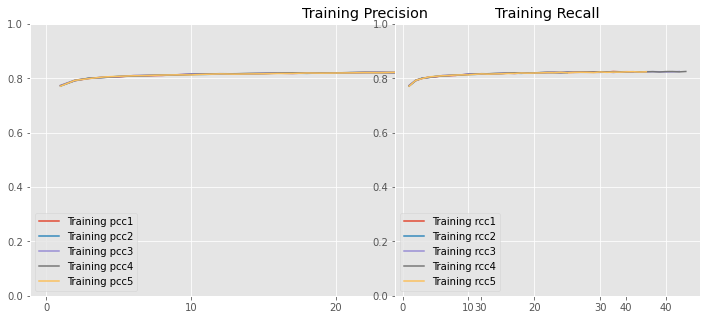

In [126]:
plot_history(history)

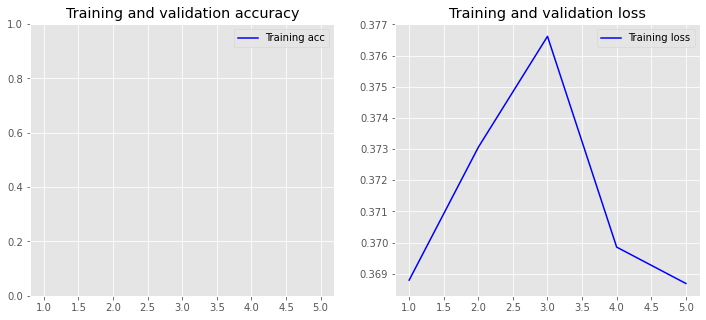

In [ ]:
plot_history2(history)

In [ ]:
model.summary()

Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, None)]            0         
_________________________________________________________________
embedding_18 (Embedding)     (None, None, 200)         11000000  
_________________________________________________________________
dropout_36 (Dropout)         (None, None, 200)         0         
_________________________________________________________________
bidirectional_36 (Bidirectio (None, None, 256)         336896    
_________________________________________________________________
bidirectional_37 (Bidirectio (None, 64)                73984     
_________________________________________________________________
dense_36 (Dense)             (None, 128)               8320      
_________________________________________________________________
dropout_37 (Dropout)         (None, 128)               0  

In [ ]:
def suggest_nn2(df, model, vectorizer):
    """
    This function generates (binary) targets from a dataframe with column "text" using trained Keras model
    
    Parameters:
        df: pandas dataframe with column "text"
        model: Keras model (trained)
    
    Output:
        predictions: list of suggested targets corresponding to string entries from the column "text"
    """
    
    string_input = keras.Input(shape=(1,), dtype="string")
    x = vectorizer(string_input)
    preds = model(x)
    end_to_end_model = keras.Model(string_input, preds)

    probabilities = end_to_end_model.predict(df["ptext"])
    
    predictions = [1 if i > 0.5 else 0 for i in probabilities]
    
    return predictions

twts = pd.read_csv(os.path.join(tweet_dir,table), engine = 'python', )
twts['Text'] = twts['Text'].astype(str)
twts['ptext'] = twts['ptext'].astype(str) 

print("predict")
predstart = datetime.datetime.now() 

predictions = suggest_nn2(twts, model,vectorizer)

pred_data = {"ID": twts['TweetId'].tolist(),"tweet": twts['Text'].tolist(), "target": predictions}

pred_df = pd.DataFrame(pred_data)
result = twts.join(pred_df.target)
name =table.replace("processed","result")

result.to_csv(os.path.join(tweet_dir,name),index =False)

In [ ]:
model.save('/content/drive/MyDrive/Capstone/model1')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Capstone/model1/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Capstone/model1/assets


In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Capstone/model1')

In [ ]:
model.summary()

Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, None)]            0         
_________________________________________________________________
embedding_18 (Embedding)     (None, None, 200)         11000000  
_________________________________________________________________
dropout_36 (Dropout)         (None, None, 200)         0         
_________________________________________________________________
bidirectional_36 (Bidirectio (None, None, 256)         336896    
_________________________________________________________________
bidirectional_37 (Bidirectio (None, 64)                73984     
_________________________________________________________________
dense_36 (Dense)             (None, 128)               8320      
_________________________________________________________________
dropout_37 (Dropout)         (None, 128)               0  

In [ ]:
def suggest_nn2(df, model):
    """
    This function generates (binary) targets from a dataframe with column "text" using trained Keras model
    
    Parameters:
        df: pandas dataframe with column "text"
        model: Keras model (trained)
    
    Output:
        predictions: list of suggested targets corresponding to string entries from the column "text"
    """
    
    string_input = keras.Input(shape=(1,), dtype="string")
    x = vectorizer(string_input)
    preds = model(x)
    end_to_end_model = keras.Model(string_input, preds)

    probabilities = end_to_end_model.predict(df["Text"])
    
    predictions = [1 if i > 0.5 else 0 for i in probabilities]
    
    return predictions

In [ ]:
predictions = suggest_nn2(pred_data, model)

submission_data = {"ID": pred_data['Tweet Id'].tolist(),"tweet": pred_data['Text'].tolist(),  "target": predictions}

submission_df = pd.DataFrame(submission_data)

submission_df.to_csv('submission.csv', index=False)

In [ ]:
submission_df


,ID,tweet,target
0,1362914863396253698,comment btsanyways recommend listening crystal...,1
1,1362914861940805632,面白かったしめっちゃきびしかったけどきっとじゅんちゃん相手だともっと優しく教えてるんだろうな...,1
2,1362914861706059779,fill bowl soap water far easier,0
3,1362914861336952833,ton fun hunt thank everyone joined u rollercoa...,0
4,1362914860795846656,fuck old folk oh fo sho wont somebody please t...,0
5,1362914860347117573,sonic bacon cheesburger toaster w fry sweet te...,0
6,1362914859533402114,“ ill considered “ people dying daily power wa...,0
7,1362914858774200325,another freeze point ready generate emergency ...,0
8,1362914857691926529,god job winter issue previous year ice snow so...,0
9,1362914857151057921,since snow class online instead lecturing onli...,0


In [ ]:
for x in range (25):
  print('trail '+ str(x))
  print(tuner.get_best_hyperparameters(25)[x].values)


trail 0
{'num_units': 128, 'activator': 'relu', 'activator2': 'sigmoid', 'dropout_in_rate': 0.7, 'dropout_rate': 0.4, 'learning_rate': 0.001, 'tuner/epochs': 3, 'tuner/initial_epoch': 0, 'tuner/bracket': 7, 'tuner/round': 0}
trail 1
{'num_units': 128, 'activator': 'sigmoid', 'activator2': 'sigmoid', 'dropout_in_rate': 0.7, 'dropout_rate': 0.4, 'learning_rate': 0.001, 'tuner/epochs': 3, 'tuner/initial_epoch': 0, 'tuner/bracket': 7, 'tuner/round': 0}
trail 2
{'num_units': 128, 'activator': 'tanh', 'activator2': 'sigmoid', 'dropout_in_rate': 0.7, 'dropout_rate': 0.4, 'learning_rate': 0.001, 'tuner/epochs': 3, 'tuner/initial_epoch': 0, 'tuner/bracket': 7, 'tuner/round': 0}
trail 3
{'num_units': 32, 'activator': 'relu', 'activator2': 'sigmoid', 'dropout_in_rate': 0.7, 'dropout_rate': 0.4, 'learning_rate': 0.001, 'tuner/epochs': 3, 'tuner/initial_epoch': 0, 'tuner/bracket': 7, 'tuner/round': 0}
trail 4
{'num_units': 128, 'activator': 'sigmoid', 'activator2': 'sigmoid', 'dropout_in_rate': 0.7

In [ ]:
tuner.get_best_hyperparameters(25)[2]

In [ ]:
def train_nn(model, train_samples, val_samples, train_labels, val_labels, vectorizer, stop = False):
    """
    This function fits the training data using validation data to calculate metrics.
    
    Parameters:
        model: preinitialized Keras model
        train_samples: list of strings in the training dataset
        val_samples: list of strings in the validation dataset
        train_labels: list of labels (0 or 1) in the training dataset
        val_labels: list of labels (0 or 1) in the validation dataset
        vectorizer: TextVectorization layer
        stop (Boolean): flag for Early Stopping (aborting training when a monitored metric has stopped improving)
    
    Returns:
        model: trained Keras model
        history: callback that can be used to track the learning process
    """
    
    print('')
    print("Training the model...")
    
    model.compile(loss="binary_crossentropy", 
              optimizer="adam", 
              metrics=["'binary_accuracy'"])
    
    x_train = vectorizer(np.array([[s] for s in train_samples])).numpy()
    x_val = vectorizer(np.array([[s] for s in val_samples])).numpy()
    
    y_train = np.asarray(train_labels).astype('float32').reshape((-1,1))
    y_val = np.asarray(val_labels).astype('float32').reshape((-1,1))

    
    
    if stop:
        early_stopping = EarlyStopping(monitor='val_loss', patience=1)
        history = model.fit(x_train, y_train, batch_size=32, epochs=50, validation_data=(x_val, y_val), callbacks=[early_stopping], verbose=1)
    else:
        history = model.fit(x_train, y_train, batch_size=32, epochs=10, validation_data=(x_val, y_val), verbose=1)
        
    return model, history

    

In [ ]:
model, history = train_nn(initial_model, train_samples, val_samples, train_labels, val_labels, vectorizer, stop=False)


Training the model...
Epoch 1/20
3301/3301 [==============================] - 43s 8ms/step - loss: 0.4005 - acc: 0.8220 - val_loss: 0.3552 - val_acc: 0.8462
Epoch 2/20
3301/3301 [==============================] - 23s 7ms/step - loss: 0.3677 - acc: 0.8402 - val_loss: 0.3472 - val_acc: 0.8529
Epoch 3/20
3301/3301 [==============================] - 23s 7ms/step - loss: 0.3538 - acc: 0.8464 - val_loss: 0.3356 - val_acc: 0.8542
Epoch 4/20
3301/3301 [==============================] - 22s 7ms/step - loss: 0.3446 - acc: 0.8506 - val_loss: 0.3334 - val_acc: 0.8566
Epoch 5/20
3301/3301 [==============================] - 23s 7ms/step - loss: 0.3368 - acc: 0.8545 - val_loss: 0.3411 - val_acc: 0.8519
Epoch 6/20
3301/3301 [==============================] - 22s 7ms/step - loss: 0.3320 - acc: 0.8574 - val_loss: 0.3388 - val_acc: 0.8566
Epoch 7/20
3301/3301 [==============================] - 23s 7ms/step - loss: 0.3257 - acc: 0.8595 - val_loss: 0.3319 - val_acc: 0.8581
Epoch 8/20
3301/3301 [==========

In [ ]:
# here we define a function to plot the history of Keras model training

plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    fig = plt.figure(figsize=(12,5))
    ax1 = fig.add_subplot(121)    
    ax1.plot(x, acc, 'b', label='Training acc')
    ax1.plot(x, val_acc, 'r', label='Validation acc')
    ax1.set_title('Training and validation accuracy')
    ax1.set_ylim(0,1)
    ax1.legend()
    
    ax2 = fig.add_subplot(122)
    ax2.plot(x, loss, 'b', label='Training loss')
    ax2.plot(x, val_loss, 'r', label='Validation loss')
    ax2.set_title('Training and validation loss')
    ax2.legend()

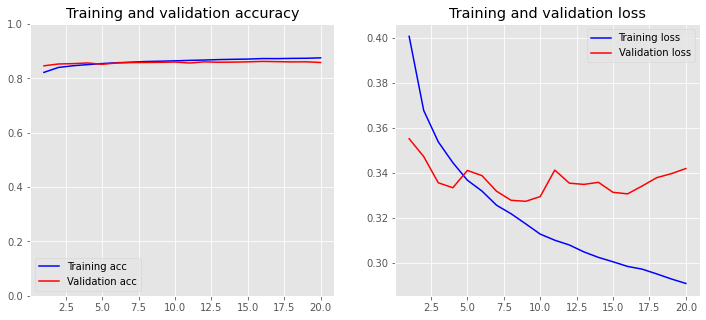

In [ ]:
plot_history(history)

In [ ]:
train_samples, val_samples, train_labels, val_labels = train_val_split(train_data, validation_split = 0.1)

embedding_matrix, vectorizer = make_embedding_matrix(train_samples, val_samples, embeddings_index)

initial_model = initialize_nn(embedding_matrix)

model, history = train_nn(initial_model, train_samples, val_samples, train_labels, val_labels, vectorizer, stop=True)

Total size of the dataset: 117339.
Training dataset: 105606.
Validation dataset: 11733.
Converted 22283 words (7717 misses).

Training the model...
Epoch 1/20
3301/3301 [==============================] - 25s 7ms/step - loss: 0.3999 - acc: 0.8237 - val_loss: 0.3656 - val_acc: 0.8420
Epoch 2/20
3301/3301 [==============================] - 23s 7ms/step - loss: 0.3656 - acc: 0.8415 - val_loss: 0.3525 - val_acc: 0.8483
Epoch 3/20
3301/3301 [==============================] - 25s 7ms/step - loss: 0.3510 - acc: 0.8478 - val_loss: 0.3505 - val_acc: 0.8480
Epoch 4/20
3301/3301 [==============================] - 24s 7ms/step - loss: 0.3421 - acc: 0.8517 - val_loss: 0.3428 - val_acc: 0.8529
Epoch 5/20
3301/3301 [==============================] - 23s 7ms/step - loss: 0.3327 - acc: 0.8560 - val_loss: 0.3436 - val_acc: 0.8526


,Unnamed: 0,Datetime,Tweet Id,Text
0,0,2021-02-19 23:59:59+00:00,1362914863396253698,"99% of the comments - BTS\n\nanyways, I recomm..."
1,1,2021-02-19 23:59:59+00:00,1362914861940805632,面白かったしめっちゃきびしかったけどきっとじゅんちゃん相手だともっと優しく教えてるんだろうな...
2,2,2021-02-19 23:59:59+00:00,1362914861706059779,@mermaid_daisy Fill a bowl with soap and water...
3,3,2021-02-19 23:59:59+00:00,1362914861336952833,"Had a TON of fun with this hunt, thank you to ..."
4,4,2021-02-19 23:59:59+00:00,1362914860795846656,@sexy_robotnik @beans_n_bops @nice_learning @B...


,Unnamed: 0,Datetime,Tweet Id,Text,FoundWord,start_text,end_text,country_predicted,country_conf,admin1,lat,lon,country_code3,geonameid,place_name,feature_class,feature_code
0,0,2021-02-19 23:59:59+00:00,1362914863396253698,"99% of the comments - BTS\n\nanyways, I recomm...",0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2021-02-19 23:59:59+00:00,1362914861940805632,面白かったしめっちゃきびしかったけどきっとじゅんちゃん相手だともっと優しく教えてるんだろうな...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2021-02-19 23:59:59+00:00,1362914861706059779,@mermaid_daisy Fill a bowl with soap and water...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,2021-02-19 23:59:59+00:00,1362914861336952833,"Had a TON of fun with this hunt, thank you to ...",0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,2021-02-19 23:59:59+00:00,1362914860795846656,@sexy_robotnik @beans_n_bops @nice_learning @B...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
def suggest_nn2(df, model):
    """
    This function generates (binary) targets from a dataframe with column "text" using trained Keras model
    
    Parameters:
        df: pandas dataframe with column "text"
        model: Keras model (trained)
    
    Output:
        predictions: list of suggested targets corresponding to string entries from the column "text"
    """
    
    string_input = keras.Input(shape=(1,), dtype="string")
    x = vectorizer(string_input)
    preds = model(x)
    end_to_end_model = keras.Model(string_input, preds)

    probabilities = end_to_end_model.predict(df["text"])
    
    predictions = [1 if i > 0.5 else 0 for i in probabilities]
    
    return predictions

In [ ]:
predictions = suggest_nn(test_data, model)

submission_data = {"ID": test_data.id.tolist(), "target": predictions}

submission_df = pd.DataFrame(submission_data)

submission_df.to_csv('submission.csv', index=False)

In [ ]:
submission_df 

,ID,target
0,368967734542864384,0
1,369089159635283968,0
2,369122655359598592,0
3,369139034133524480,1
4,369142238564974592,0
...,...,...
39108,1055859783889240064,1
39109,1055862228925276162,1
39110,1056477734606684160,0
39111,818030041930014720,0


In [ ]:
test_data.head()

,id,event,source,text,lang,lang_confidence,class_label,class_label_cat,processed_txt
0,368967734542864384,2013_manila_floods,crisislext26,rt ancalerts pagasa yellow advisory metro mani...,en,1.00000,informative,0,pagasa 12 20pm yellow advisory for metro moder...
1,369089159635283968,2013_manila_floods,crisislext26,rt piaalerts pagasa red rainfall warning weath...,en,0.72282,informative,0,pagasa red rainfall warning no D weather syste...
2,369122655359598592,2013_manila_floods,crisislext26,rt ancalerts tropical storm maring continue en...,en,1.00000,informative,0,tropical storm maring will continue to enhance...
3,369139034133524480,2013_manila_floods,crisislext26,cant sleep rain maringph ughh,en,1.00000,informative,0,can t sleep because of this rain #maringph #ughh
4,369142238564974592,2013_manila_floods,crisislext26,findaiba well bad u heard news already waistde...,en,1.00000,informative,0,well it s not that bad for us here but i heard...
